In [122]:
import pystare
import pystareplotlib
import pystareplotlib.pystareplotlib as psplot
from pystareplotlib.pystareplotlib import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import ListedColormap

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.geodesic import Geodesic

import numpy
import math
from math import sqrt,sin,cos

import pyproj
import scipy.linalg
from scipy.linalg import expm, norm

In [2]:
# Define Global Constants and State Variables
# -------------------------------------------

# Set up the projection and transformation
# PROJ = ccrs.PlateCarree()
# PROJ = ccrs.Robinson()
PROJ = ccrs.Mollweide()
TRANSF = ccrs.Geodetic()
USR_SET_GLOBAL = True

# Plot options
usr_plot_options = {'projection': PROJ, 'transform': TRANSF}
DEFAULT_DPI = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = 1.5 * DEFAULT_DPI
mpl.rcParams['legend.fontsize'] = 6

In [7]:
nearside_plot_options = {
    'projection':
    ccrs.NearsidePerspective(central_longitude=0.0
                             ,central_latitude=45.0
                             ,satellite_height=35785831
                             ,false_easting=0
                             ,false_northing=0
                             ,globe=None)
    ,'transform': ccrs.Geodetic()
}
    

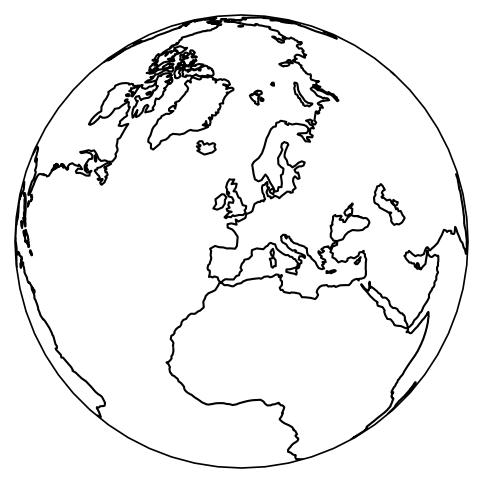

In [8]:
figax,sivs_cache,sivs_triang = hello_plot(
    set_coastlines=True
    ,plot_options=nearside_plot_options
    ,set_global=False
    ,show_fig=False)

plt.show() # May have to Cell->Current Outputs->Toggle Scrolling to see full figure.
del figax

In [12]:
crs_geocentric = ccrs.Geocentric()
crs_geodetic   = ccrs.Geodetic()

In [55]:
x=numpy.array([6378137,0,0],dtype=numpy.double)
y=numpy.array([0,6378137,0],dtype=numpy.double)
z=numpy.array([0,0,6.35675231e+06],dtype=numpy.double)
# z = None
crs_geodetic.transform_points(crs_geocentric,x,y,z)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.00000000e+01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  9.00000000e+01, -4.24517971e-03]])

In [64]:
def RN(phi,lam):
    a=6378137.0; c=6356752.314245; fi=298.257223563
    return a/sqrt(1-((sin(phi)**2) * (a*a-c*c))/(a*a)),a,c

In [65]:
def xyz(phi,lam,h):
    rn,a,c=RN(phi,lam)
    return (rn+h)*cos(phi)*cos(lam),\
           (rn+h)*cos(phi)*sin(lam),\
           (rn*c*c/(a*a)+h)*sin(phi)
                        

In [66]:
xyz(0,0,1)

(6378138.0, 0.0, 0.0)

In [ ]:
def phi_lam_h(x,y,z):
    w = sqrt(x*x + y*y)
    

In [94]:

xyz_to_lonlatalt= pyproj.Transformer.from_crs(
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},
    )

lonlatalt_to_xyz = pyproj.Transformer.from_crs(
    {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'},
    {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'},
    )


In [93]:

x = -652954.1006
y = 4774619.7919
z = -2217647.7937
lon1, lat1, alt1 = transformer.transform(x,y,z,radians=False)
print (lat1, lon1, alt1 )


lon1=0
lat1=0
alt1=0
x,y,z = transformer.transform(lon1,lat1,alt1,radians=False)
print(x,y,z)

6378137.0 0.0 0.0


In [100]:
xyz_to_lonlatalt.transform(1,0,0,radians=False)

(0.0, 90.0, -6356752.314245179)

In [103]:
lonlatalt_to_xyz.transform(0.0, 90.0, 0)

(3.9186209248144716e-10, 0.0, 6356752.314245179)

In [110]:
def to_xyz(lla):
    return lonlatalt_to_xyz.transform(lla[0],lla[1],lla[2],radians=False)
def to_lla(xyz):
    return xyz_to_lonlatalt.transform(xyz[0],xyz[1],xyz[2],radians=False)

In [224]:
# def norm(x):
#     return x/numpy.sqrt((x*x).sum())

def tri(center_lon,center_lat,delta_lon,delta_lat):
    x = numpy.array(lonlatalt_to_xyz.transform(center_lon,center_lat,0),dtype=numpy.double)
    p = numpy.array(lonlatalt_to_xyz.transform(center_lon+delta_lon,center_lat+delta_lat,0),dtype=numpy.double)
    n = numpy.cross(x,p); n = n/norm(n)
    return x,p,n

def rot(a,n,theta):
    M = expm(numpy.cross(numpy.eye(3),n*(theta*numpy.pi/180.0)))
    return numpy.dot(M,a)

def rotM(a,M):
    return numpy.dot(M,a)

def make_rot_matrix(n,theta):
    return expm(numpy.cross(numpy.eye(3),n*(theta*numpy.pi/180.0)))

def patch(x,n,along,across):
    xp = rot(x,n,along/2.0)
    xm = rot(x,n,-along/2.0)
    
    np  = numpy.cross(n,xp); np = np/norm(np)
    xpp = rot(xp,np,across/2.0)
    xpm = rot(xp,np,-across/2.0)
    
    nm  = numpy.cross(n,xm); nm = nm/norm(nm)
    xmp = rot(xm,nm,across/2.0)
    xmm = rot(xm,nm,-across/2.0)
    
    return [xmp,xpp,xpm,xmm]

def make_periodic(a):
    return a+a[0:1]

def patch_geodetic(p):
    return zip(*map(to_lla,p))

def patch_periodic(p):
    return map(make_periodic,patch_geodetic(p))

def make_swath(center_lon=0,center_lat=0,along=10,across=10,delta_deg=10,delta_lon=0.0,delta_lat=1.0):
    t__ = tri(center_lon,center_lat,delta_lon,delta_lat)
    n  = t__[2]
    c0 = t__[0]
    centers      = [ rot(c0,n,i) for i in range(0,361,delta_deg) ]
    centers_llas = [ to_lla(c) for c in centers ]
    centers_lons,centers_lats,alts = zip(*centers_llas)
    patches      = [ patch(c,n,delta_deg,delta_deg) for c in centers ]
    pp_lons = []
    pp_lats = []
    for p in patches:
        pp = list(patch_periodic(p))
        pp_lons.append(pp[0]); pp_lats.append(pp[1])
    return centers_lons,centers_lats,pp_lons,pp_lats

In [233]:
centers_lons,centers_lats,pp_lons,pp_lats = make_swath(center_lat=60)
centers_lons1,centers_lats1,pp_lons1,pp_lats1 = make_swath(center_lat=60,delta_lon=0.7,delta_lat=0.2)

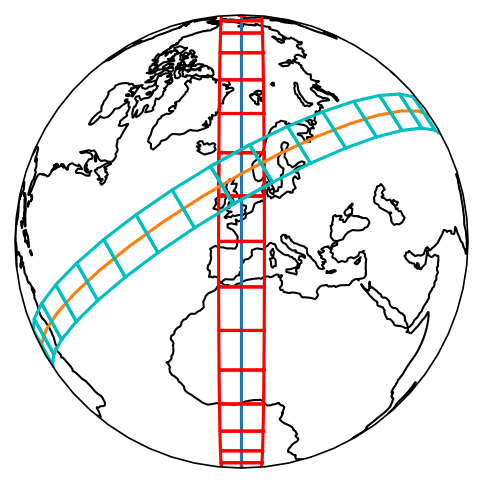

In [234]:
figax,sivs_cache,sivs_triang = hello_plot(
    set_coastlines=True
    ,plot_options=nearside_plot_options
    ,set_global=True
    ,show_fig=False)

figax.ax.plot(centers_lons,centers_lats,transform=ccrs.Geodetic())

for i in range(len(pp_lons)):
    figax.ax.plot(pp_lons[i],pp_lats[i],transform=ccrs.Geodetic(),color='r')
    
figax.ax.plot(centers_lons1,centers_lats1,transform=ccrs.Geodetic())

for i in range(len(pp_lons1)):
    figax.ax.plot(pp_lons1[i],pp_lats1[i],transform=ccrs.Geodetic(),color='c')

plt.show() # May have to Cell->Current Outputs->Toggle Scrolling to see full figure.
del figax

In [188]:
t_ = tri(0,60,0.2,1)
t_

(array([3197104.58692395,       0.        , 5500477.13393864]),
 array([3100111.25352282,   10821.47366258, 5555342.60774922]),
 array([-0.0835701 , -0.99531732,  0.0485744 ]))

In [189]:
p = patch(t_[0],t_[2],2,2)
p

[array([3300942.44710555,   99783.45640597, 5437880.89823936]),
 array([3109877.46910287,  121245.69996055, 5548935.75815393]),
 array([3091319.13701087,  -99783.45640597, 5559722.62758584]),
 array([3282384.11501355, -121245.69996055, 5448667.76767126])]

In [190]:
p_lla = list(map(to_lla,p))
p_lla

[(1.7314541385474125, 58.89998698544579, -360.8675694093108),
 (2.23267649637903, 60.87707668280535, 282.15781872347),
 (-1.8487856851731612, 61.075573617426826, 345.29767170455307),
 (-2.1154470985038243, 59.08705090483612, -298.9714115578681)]

In [191]:
p_llas = list(zip(*p_lla))
p_llas

[(1.7314541385474125,
  2.23267649637903,
  -1.8487856851731612,
  -2.1154470985038243),
 (58.89998698544579, 60.87707668280535, 61.075573617426826, 59.08705090483612),
 (-360.8675694093108, 282.15781872347, 345.29767170455307, -298.9714115578681)]

In [192]:
list(patch_geodetic(p))

[(1.7314541385474125,
  2.23267649637903,
  -1.8487856851731612,
  -2.1154470985038243),
 (58.89998698544579, 60.87707668280535, 61.075573617426826, 59.08705090483612),
 (-360.8675694093108, 282.15781872347, 345.29767170455307, -298.9714115578681)]

In [193]:
list(patch_periodic(p))

[(1.7314541385474125,
  2.23267649637903,
  -1.8487856851731612,
  -2.1154470985038243,
  1.7314541385474125),
 (58.89998698544579,
  60.87707668280535,
  61.075573617426826,
  59.08705090483612,
  58.89998698544579),
 (-360.8675694093108,
  282.15781872347,
  345.29767170455307,
  -298.9714115578681,
  -360.8675694093108)]

In [194]:
list(map(to_lla,t_))

[(0.0, 59.99999999999999, 0.0),
 (0.2, 61.0, 0.0),
 (-94.79948396421041, 90.0, -6356752.265670782)]

In [210]:
delta_deg = 10
centers = [ rot(t_[0],t_[2],i) for i in range(0,361,delta_deg) ]

In [206]:
llas = [ to_lla(c) for c in centers ]
llas

[(0.0, 59.99999999999999, 0.0),
 (2.7816836634612785, 69.88979370309163, 2833.1048175171018),
 (10.527435319108445, 79.64329896475182, 4683.136261201464),
 (84.1667338812244, 87.23394092580125, 5329.689872830175),
 (159.72320564713593, 79.73941344005719, 4695.867633837275),
 (167.57837019895712, 69.98872628308591, 2857.0527073126286),
 (170.38165363779981, 60.09963446350773, 32.3078485019505),
 (171.88154415081507, 50.15906993571306, -3440.7870960962027),
 (172.86234992596033, 40.18320794952639, -7145.39762919303),
 (173.5908572966335, 30.178342035447457, -10634.733903880231),
 (174.18489048585616, 20.149941384066583, -13485.905264652334),
 (174.70727552280815, 10.104658228944238, -15351.866496492177),
 (175.1980765909859, 0.05050041866601135, -16004.759129082784),
 (175.68872633750195, -10.003702474175268, -15364.718829688616),
 (176.2106180943931, -20.049116547210943, -13510.038473200984),
 (176.80367469939884, -30.077722303113756, -10667.204715381376),
 (177.5303818720501, -40.08285

In [207]:
lons,lats,alts = zip(*llas)

In [211]:
n  = t_[2]
ps = [ patch(c,n,delta_deg,delta_deg) for c in centers ]
ps

[[array([3694495.89258142,  498505.37114929, 5155474.65664862]),
  array([2743820.71439869,  605294.28887113, 5708046.35158201]),
  array([2651142.07873612, -498505.37114929, 5761915.00405915]),
  array([3601817.25691886, -605294.28887113, 5209343.30912577])],
 [array([2743820.71439869,  605294.28887113, 5708046.351582  ]),
  array([1711183.9289727 ,  710460.84297938, 6086363.56066006]),
  array([1618505.29331013, -393338.81704104, 6140232.2131372 ]),
  array([2651142.07873612, -498505.37114929, 5761915.00405915])],
 [array([1711183.9289727 ,  710460.84297938, 6086363.56066005]),
  array([ 627961.6824892 ,  810809.60094431, 6278931.30692269]),
  array([ 535283.04682663, -292990.05907611, 6332799.95939984]),
  array([1618505.29331013, -393338.81704104, 6140232.2131372 ])],
 [array([ 627961.6824892 ,  810809.60094431, 6278931.30692269]),
  array([-472932.86522932,  903291.51653407, 6279898.51684369]),
  array([-565611.50089188, -200508.14348635, 6333767.16932084]),
  array([ 535283.04682

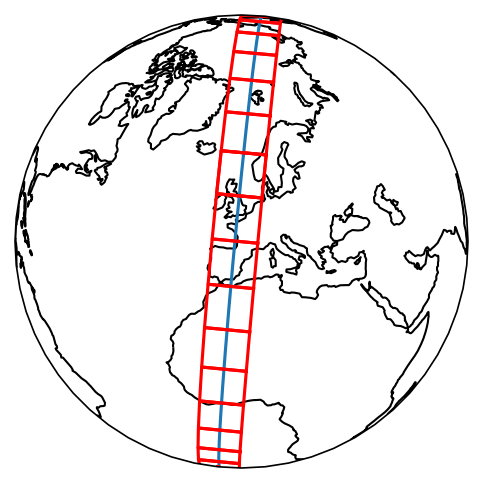

In [213]:
figax,sivs_cache,sivs_triang = hello_plot(
    set_coastlines=True
    ,plot_options=nearside_plot_options
    ,set_global=True
    ,show_fig=False)

figax.ax.plot(lons,lats,transform=ccrs.Geodetic())

for p in ps:
    pp = list(patch_periodic(p))
    pp_lons = pp[0]; pp_lats = pp[1]
    figax.ax.plot(pp_lons,pp_lats,transform=ccrs.Geodetic(),color='r')

plt.show() # May have to Cell->Current Outputs->Toggle Scrolling to see full figure.
del figax